Example notebook for pulling in one year of IFS data and combining with madis

In [1]:
import os
import xarray as xr
import glob
import numpy as np
import sys
import importlib
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sys.path.insert(0, "/home/kylabazlen/")
processing = importlib.import_module("2026_nvhackathon.validation.processing")
subset_grid_to_point_xy = processing.subset_grid_to_point_xy
forecast_obs_merge = processing.forecast_obs_merge
convert_1d_to_2d_latlon = processing.convert_1d_to_2d_latlon
metrics = importlib.import_module("2026_nvhackathon.validation.metrics")
add_gof_stats = metrics.add_gof_stats

In [4]:
observations = '/project/cowy-nvhackathon/cowy-wildfire/data/observations/cowy_madis_metar_mesonet_2024.nc'
ifs_paths = sorted(glob.glob("/project/cowy-nvhackathon/cowy-wildfire/data/nwp/ifs_yearly/*"))

In [5]:
# Open the observations file
obs_ds = xr.open_dataset(observations) #space, time diminsions

# Open the first IFS file
ifs_f72 = xr.open_dataset(ifs_paths[0]) #time, latitude, longitude diminsions

In [6]:
#drop stations with all NA windspeed data
has_data_mask = ~obs_ds['windspeed_10m'].isnull().all(dim='time')

obs_ds_clean = obs_ds.sel(space=has_data_mask)

print(f"Original stations: {obs_ds.dims['space']}")
print(f"Stations with data: {obs_ds_clean.dims['space']}")

Original stations: 4372
Stations with data: 3394


In [7]:
ds = convert_1d_to_2d_latlon(ds = ifs_f72)
ifs_subset = subset_grid_to_point_xy(ds=ds, point_ds=obs_ds_clean)
all_data = forecast_obs_merge(ds1=ifs_subset, ds2=obs_ds_clean, ds1_timevar="valid_time", ds2_timevar="time")

In [18]:
#add windspeed error as a variable
all_data['ws_error'] = all_data['obs_windspeed_10m'] - all_data['ws_10']

In [19]:
all_data['ws_error_mean'] = all_data['ws_error'].mean(dim='time')


In [20]:
sys.path.insert(0, "/home/kylabazlen/")
plotting = importlib.import_module("2026_nvhackathon.validation.plotting")
configure_style = plotting.configure_style
filter_df_by_location = plotting.filter_df_by_location
filter_df_by_time = plotting.filter_df_by_time
COLORS = plotting.COLORS
MARKERS = plotting.MARKERS
plot_timeseries = plotting.plot_timeseries
plot_station_gof_map = plotting.plot_station_gof_map

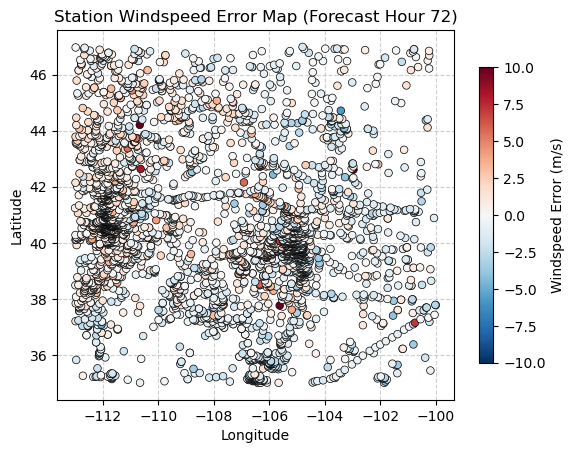

In [22]:
# Convert xarray to DataFrame with required columns
df_plot = all_data[['ws_error_mean', 'latitude', 'longitude']].to_dataframe().reset_index()

# Then plot
result = plot_station_gof_map(
    df_plot,
    rmse_col='ws_error_mean',
    lat_col='latitude',
    lon_col='longitude',
    title='Station Windspeed Error Map (Forecast Hour 72)',
    cbar_label='Windspeed Error (m/s)',
    cmap='RdBu_r',
    vmin=-10, vmax=10
)


In [13]:
all_data_gof = add_gof_stats(ds = all_data, var1 = "ws_10", var2 = "obs_windspeed_10m")

In [20]:
all_data_gof

<xarray.Dataset> Size: 721MB
Dimensions:                               (time: 664, space: 3394)
Coordinates:
  * time                                  (time) datetime64[ns] 5kB 2024-02-0...
  * space                                 (space) object 27kB 0 1 ... 3392 3393
    step                                  timedelta64[ns] 8B 3 days
    valid_time                            (time) datetime64[ns] 5kB 2024-02-0...
    gribfile_projection                   float64 8B nan
    surface                               float64 8B 0.0
    latitude                              (space) float32 14kB 35.0 ... 46.99
    longitude                             (space) float32 14kB -106.4 ... -104.8
Data variables: (12/43)
    t_500hPa                              (time, space) float64 18MB 248.8 .....
    t_700hPa                              (time, space) float64 18MB 266.4 .....
    t_850hPa                              (time, space) float64 18MB 279.4 .....
    t_925hPa                              (time, space) float64 18MB 283.9 .....
    t_1000hPa                             (time, space) float64 18MB 288.1 .....
    r_500hPa                              (time, space) float64 18MB 45.33 .....
    ...                                    ...
    obs_v_10m                             (space, time) float64 18MB 0.9304 ....
    ws_error                              (time, space) float64 18MB -2.05 .....
    ws_10_vs_obs_windspeed_10m_RMSE       (space) float64 27kB 2.218 2.5 ... 2.3
    ws_10_vs_obs_windspeed_10m_MBE        (space) float64 27kB -0.1553 ... -1...
    ws_10_vs_obs_windspeed_10m_SDE        (space) float64 27kB 2.214 ... 1.68
    ws_10_vs_obs_windspeed_10m_residuals  (space, time) float64 18MB 2.05 ......
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://storage.googleapis.com/ecmwf-open-data/2...
    local_grib:              /scratch/kylabazlen/herbie_downloads/ifs/2024072...
    search:                  :t:500:pl:

In [14]:
def add_gof_stats(
    ds: xr.Dataset,
    var1: str,
    var2: str,
    output_prefix: str | None = None,
    ) -> xr.Dataset:
    """
    Compute goodness-of-fit (GOF) statistics between two variables.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the variables to compare.
    var1 : str
        Name of the first variable (e.g., observed).
    var2 : str
        Name of the second variable (e.g., modeled).
    output_prefix : str, optional
        Prefix for output variable names. If None, uses "{var1}_vs_{var2}".

    Returns
    -------
    xarray.Dataset
        The input dataset with new variables: RMSE, MBE, SDE, and residuals.
    """
    data1 = ds[var1]
    data2 = ds[var2]

    valid = np.isfinite(data1) & np.isfinite(data2)
    res = (data2 - data1).where(valid)

    rmse = np.sqrt((res**2).mean(dim="time", skipna=True))
    mbe = res.mean(dim="time", skipna=True)
    sde = res.std(dim="time", skipna=True, ddof=1)

    prefix = output_prefix if output_prefix else f"{var1}_vs_{var2}"
    
    ds[f"{prefix}_RMSE"] = rmse
    ds[f"{prefix}_MBE"] = mbe
    ds[f"{prefix}_SDE"] = sde
    ds[f"{prefix}_residuals"] = res

    return ds

In [15]:
all_data_gof['ws_10_vs_obs_windspeed_10m_MBE']

<xarray.DataArray 'ws_10_vs_obs_windspeed_10m_MBE' (space: 3394)> Size: 27kB
array([-0.15526354, -1.89297602,  0.76179043, ..., -0.78776403,
       -0.10336341, -1.57172466], shape=(3394,))
Coordinates:
  * space                (space) object 27kB 0 1 2 3 4 ... 3390 3391 3392 3393
    step                 timedelta64[ns] 8B 3 days
    gribfile_projection  float64 8B nan
    surface              float64 8B 0.0
    latitude             (space) float32 14kB 35.0 35.01 35.01 ... 46.97 46.99
    longitude            (space) float32 14kB -106.4 -106.3 ... -113.0 -104.8
Attributes: (12/35)
    GRIB_paramId:                             165
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_stepRange:                           72
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            eastward_wind
    grid_mapping:                             gribfile_projection

In [27]:
all_data_gof = xr.open_dataset("/project/cowy-nvhackathon/lucasnorth/datasets/ds_ifs_point_gof_filtered.nc")

In [28]:
all_data_gof

<xarray.Dataset> Size: 517MB
Dimensions:                               (time: 664, space: 2435)
Coordinates:
  * time                                  (time) datetime64[ns] 5kB 2024-02-0...
  * space                                 (space) int64 19kB 0 1 3 ... 3392 3393
    step                                  timedelta64[ns] 8B ...
    valid_time                            (time) datetime64[ns] 5kB ...
    gribfile_projection                   float64 8B ...
    surface                               float64 8B ...
    latitude                              (space) float32 10kB ...
    longitude                             (space) float32 10kB ...
Data variables: (12/43)
    t_500hPa                              (time, space) float64 13MB ...
    t_700hPa                              (time, space) float64 13MB ...
    t_850hPa                              (time, space) float64 13MB ...
    t_925hPa                              (time, space) float64 13MB ...
    t_1000hPa                             (time, space) float64 13MB ...
    r_500hPa                              (time, space) float64 13MB ...
    ...                                    ...
    obs_v_10m                             (space, time) float64 13MB ...
    ws_error                              (time, space) float64 13MB ...
    ws_10_vs_obs_windspeed_10m_RMSE       (space) float64 19kB ...
    ws_10_vs_obs_windspeed_10m_MBE        (space) float64 19kB ...
    ws_10_vs_obs_windspeed_10m_SDE        (space) float64 19kB ...
    ws_10_vs_obs_windspeed_10m_residuals  (space, time) float64 13MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://storage.googleapis.com/ecmwf-open-data/2...
    local_grib:              /scratch/kylabazlen/herbie_downloads/ifs/2024072...
    search:                  :t:500:pl:

In [42]:
all_data_gof

<xarray.Dataset> Size: 517MB
Dimensions:                               (time: 664, space: 2435)
Coordinates:
  * time                                  (time) datetime64[ns] 5kB 2024-02-0...
  * space                                 (space) int64 19kB 0 1 3 ... 3392 3393
    step                                  timedelta64[ns] 8B 3 days
    valid_time                            (time) datetime64[ns] 5kB ...
    gribfile_projection                   float64 8B nan
    surface                               float64 8B 0.0
    latitude                              (space) float32 10kB ...
    longitude                             (space) float32 10kB ...
Data variables: (12/43)
    t_500hPa                              (time, space) float64 13MB ...
    t_700hPa                              (time, space) float64 13MB ...
    t_850hPa                              (time, space) float64 13MB ...
    t_925hPa                              (time, space) float64 13MB ...
    t_1000hPa                             (time, space) float64 13MB ...
    r_500hPa                              (time, space) float64 13MB ...
    ...                                    ...
    obs_v_10m                             (space, time) float64 13MB ...
    ws_error                              (time, space) float64 13MB ...
    ws_10_vs_obs_windspeed_10m_RMSE       (space) float64 19kB ...
    ws_10_vs_obs_windspeed_10m_MBE        (space) float64 19kB -0.1553 ... -1...
    ws_10_vs_obs_windspeed_10m_SDE        (space) float64 19kB ...
    ws_10_vs_obs_windspeed_10m_residuals  (space, time) float64 13MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://storage.googleapis.com/ecmwf-open-data/2...
    local_grib:              /scratch/kylabazlen/herbie_downloads/ifs/2024072...
    search:                  :t:500:pl:

In [47]:
# Get the MBE values as a pandas Series
mbe = all_data_gof['ws_10_vs_obs_windspeed_10m_MBE'].to_pandas()

# nlargest(2) gives top 2, take the second one's index
closest_to_zero_station = mbe.abs().idxmin()
filtered = all_data_gof.sel(space=closest_to_zero_station)

In [29]:
max_station = all_data_gof['ws_10_vs_obs_windspeed_10m_MBE'].idxmax().item()
filtered = all_data_gof.sel(space=max_station)


In [35]:
filtered

<xarray.Dataset> Size: 223kB
Dimensions:                               (time: 664)
Coordinates:
  * time                                  (time) datetime64[ns] 5kB 2024-02-0...
    step                                  timedelta64[ns] 8B 3 days
    valid_time                            (time) datetime64[ns] 5kB ...
    gribfile_projection                   float64 8B nan
    surface                               float64 8B 0.0
    latitude                              float32 4B ...
    longitude                             float32 4B ...
    space                                 int64 8B 2685
Data variables: (12/43)
    t_500hPa                              (time) float64 5kB ...
    t_700hPa                              (time) float64 5kB ...
    t_850hPa                              (time) float64 5kB ...
    t_925hPa                              (time) float64 5kB ...
    t_1000hPa                             (time) float64 5kB ...
    r_500hPa                              (time) float64 5kB ...
    ...                                    ...
    obs_v_10m                             (time) float64 5kB ...
    ws_error                              (time) float64 5kB ...
    ws_10_vs_obs_windspeed_10m_RMSE       float64 8B ...
    ws_10_vs_obs_windspeed_10m_MBE        float64 8B 8.273
    ws_10_vs_obs_windspeed_10m_SDE        float64 8B ...
    ws_10_vs_obs_windspeed_10m_residuals  (time) float64 5kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://storage.googleapis.com/ecmwf-open-data/2...
    local_grib:              /scratch/kylabazlen/herbie_downloads/ifs/2024072...
    search:                  :t:500:pl:

In [36]:
filtered['ws_10']
filtered['obs_windspeed_10m']

<xarray.DataArray 'obs_windspeed_10m' (time: 664)> Size: 5kB
[664 values with dtype=float64]
Coordinates:
  * time                 (time) datetime64[ns] 5kB 2024-02-04 ... 2024-12-31T...
    step                 timedelta64[ns] 8B 3 days
    valid_time           (time) datetime64[ns] 5kB ...
    gribfile_projection  float64 8B nan
    surface              float64 8B 0.0
    latitude             float32 4B ...
    longitude            float32 4B ...
    space                int64 8B 2685

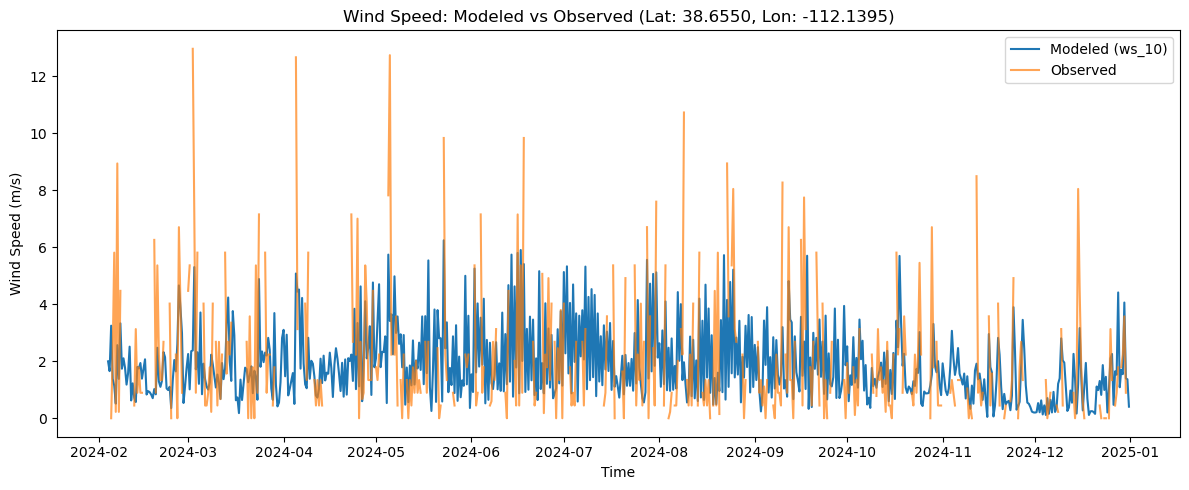

In [48]:
import matplotlib.pyplot as plt

# Extract lat/lon values (adjust variable names if needed)
lat = float(filtered['latitude'].values)
lon = float(filtered['longitude'].values)

plt.figure(figsize=(12, 5))
plt.plot(filtered['time'], filtered['ws_10'], label='Modeled (ws_10)')
plt.plot(filtered['time'], filtered['obs_windspeed_10m'], label='Observed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title(f'Wind Speed: Modeled vs Observed (Lat: {lat:.4f}, Lon: {lon:.4f})')
plt.legend()
plt.tight_layout()
plt.show()